# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import numpy as np
from sklearn.linear_model import LinearRegression

dirscripts  = os.path.join(os.path.dirname(os.getcwd()), "Scripts")
sys.path.insert(0, dirscripts)

#Eigen styling importeren 
import Styling
# Eigen script met functie 
from Tools import populairste_unisex_namen

## Utilities

In [2]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [3]:
# Current directory notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Path naar files
data_dir = os.path.abspath(os.path.join(notebook_dir, '..', 'data'))

# Lijs van alle files
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Lijst met juiste en foute df
dataframes = []
dfs_wrong = [] 

for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    #Nieuwe kolom geboortedag uit naam file 
    df['geboortedag'] = pd.to_datetime(file[:-4], format='%Y-%m-%d', errors='coerce')  
    

    # Foute datums zoeken ('2019-2-29')
    if file == '2019-2-29.csv':
        # Als hij niet al in het df staat
        if not any(df['geboortedag'].dt.strftime('%Y-%m-%d') == file[:-4]):
            # Aan df toevoegen met extra kolom 'reden'
            df['reden'] = '2019 is geen schrikkeljaar'
            dfs_wrong.append(df)
    else: dataframes.append(df)

# Concatenate dataframes
df = pd.concat(dataframes, ignore_index=True)
df_wrong = pd.concat(dfs_wrong, ignore_index=True)

In [4]:
# Convert 'verwachte datum' naar datetime
df['verwachte datum'] = pd.to_datetime(df['verwachte datum'], format='%m/%d/%Y')

In [5]:
# 'dag van het jaar' kolom voor 'verwachte datum'
df['dag_van_het_jaar_verwacht'] = df['verwachte datum'].dt.dayofyear.astype(int)

# 'dag van het jaar' kolom 'geboortedag'
df['dag_van_het_jaar_geboorte'] = df['geboortedag'].dt.dayofyear.astype(int)

## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

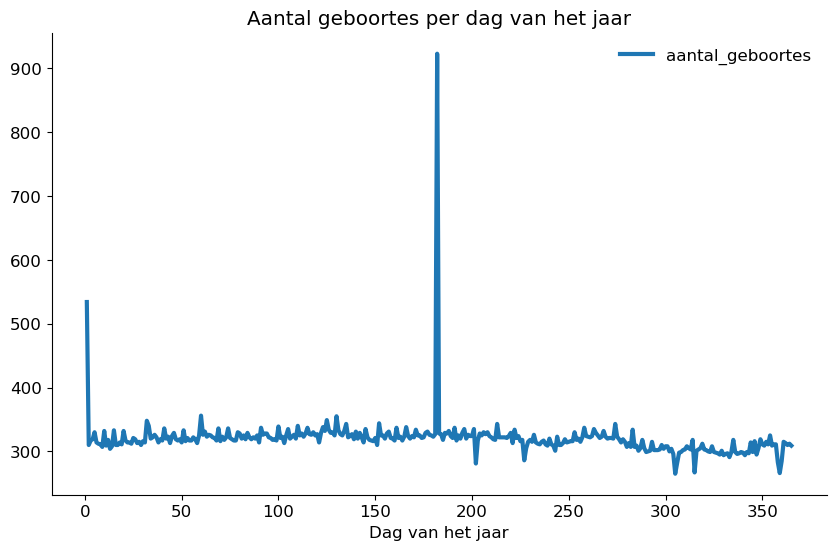

In [6]:
# Count geboorted per dag
birth_counts = df['dag_van_het_jaar_geboorte'].value_counts().sort_index()

# Line plot
plt.plot(birth_counts.index, birth_counts.values, label= 'aantal_geboortes')
plt.title('Aantal geboortes per dag van het jaar')
plt.xlabel('Dag van het jaar')
plt.legend()
plt.show()

##

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [7]:
# Counts geboortedag
births_count = df['geboortedag'].value_counts().sort_index()

# Mediaan
median_births = births_count.median()

# Thresholds zetten
threshold_upper = median_births * 1.5
threshold_lower = median_births * 0.5


outliers = births_count[(births_count > threshold_upper) | (births_count < threshold_lower)]


print(f"Outlier dates: {outliers}")

Outlier dates: geboortedag
2019-01-01    534
2019-07-01    923
Name: count, dtype: int64


Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [8]:
# Append '2019-01-01' en '2019-07-01' 
wrong_records = df[df['geboortedag'].isin([pd.Timestamp('2019-01-01'), pd.Timestamp('2019-07-01')])].copy()
wrong_records['reden'] = 'datum mogelijks niet correct genoteerd'
df_wrong = pd.concat([df_wrong, wrong_records], ignore_index=True)

# Verwijder ze uit df
cleaned_df = df[~df['geboortedag'].isin([pd.Timestamp('2019-01-01'), pd.Timestamp('2019-07-01')])]

Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

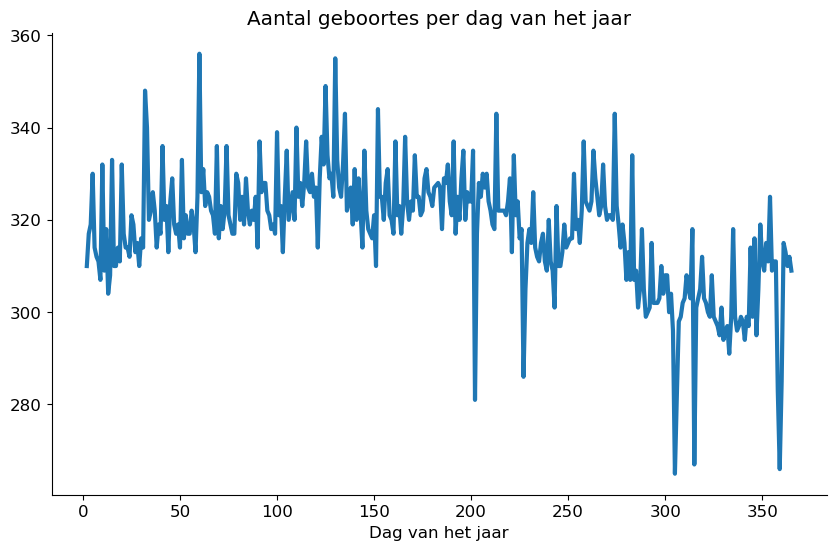

In [9]:
# Count geboorted per dag
birth_counts = cleaned_df['dag_van_het_jaar_geboorte'].value_counts().sort_index()

# Line plot
plt.plot(birth_counts.index, birth_counts.values)
plt.title('Aantal geboortes per dag van het jaar')
plt.xlabel('Dag van het jaar')
plt.show()

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [10]:
# Midden van het jaar berekenen
midpoint_date = cleaned_df['dag_van_het_jaar_geboorte'].min() + (cleaned_df['dag_van_het_jaar_geboorte'].max() - cleaned_df['dag_van_het_jaar_geboorte'].min()) / 2
birth_counts_second_half = birth_counts[birth_counts.index > midpoint_date]

# Kwartielen berekenen
Q1_second_half = birth_counts_second_half.quantile(0.25)
Q3_second_half = birth_counts_second_half.quantile(0.75)
IQR_second_half = Q3_second_half - Q1_second_half

#Treshhold voor uitschieters
threshold = 1
extreme_outliers_second_half = birth_counts_second_half[(birth_counts_second_half < (Q1_second_half - threshold * IQR_second_half)) | (birth_counts_second_half > (Q3_second_half + threshold * IQR_second_half))]

print(extreme_outliers_second_half)

dag_van_het_jaar_geboorte
202    281
213    343
274    343
305    265
306    282
315    267
358    283
359    266
Name: count, dtype: int64


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

In [11]:
#Kolom weekdag
cleaned_df.loc[:, 'weekdag'] = cleaned_df['geboortedag'].dt.strftime('%A')

C:\Users\maiaf\AppData\Local\Temp\ipykernel_11984\3907894694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, 'weekdag'] = cleaned_df['geboortedag'].dt.strftime('%A')


In [12]:
#Kolom week van het jaar
cleaned_df.loc[:, 'week_van_het_jaar_geboorte'] = cleaned_df['geboortedag'].dt.isocalendar().week

C:\Users\maiaf\AppData\Local\Temp\ipykernel_11984\2993518357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, 'week_van_het_jaar_geboorte'] = cleaned_df['geboortedag'].dt.isocalendar().week


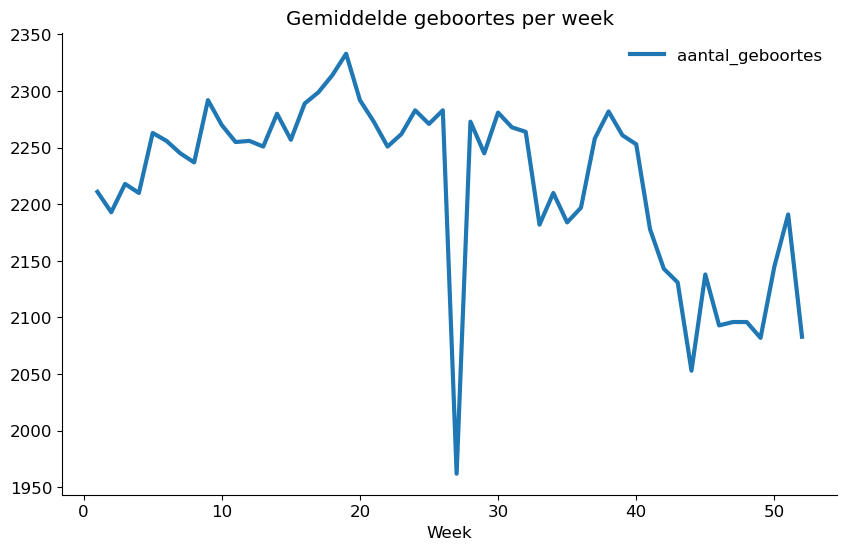

In [13]:
#Gemiddelde elke week
gemiddelde_per_week = cleaned_df.groupby('week_van_het_jaar_geboorte').size()
gemiddelde_per_week.plot(kind='line', label = 'aantal_geboortes')
plt.title('Gemiddelde geboortes per week')
plt.xlabel('Week')
plt.legend()
plt.show()

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

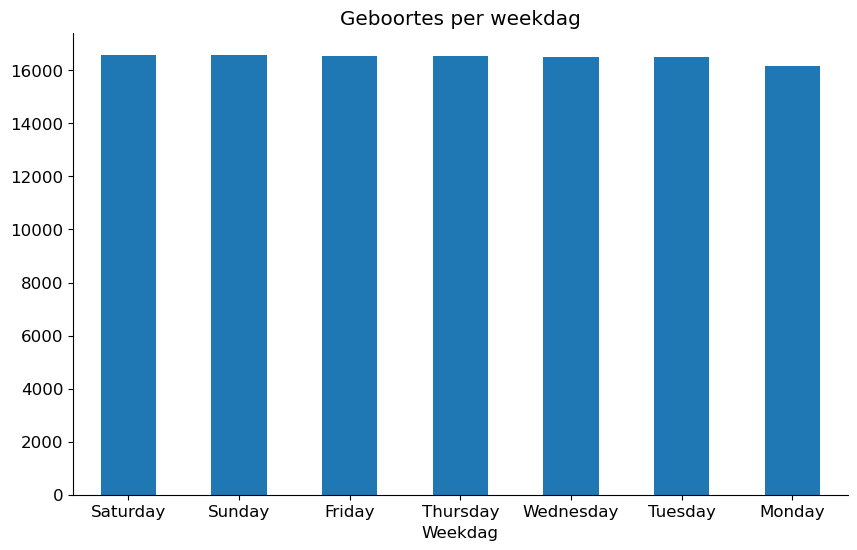

In [14]:
weekday_counts = cleaned_df['weekdag'].value_counts()

# Bar plot
weekday_counts.plot(kind='bar')
plt.title('Geboortes per weekdag')
plt.xlabel('Weekdag')
plt.xticks(rotation=0)
plt.show()

In [15]:
cleaned_df.dtypes

gemeente                              object
naam                                  object
geslacht                              object
verwachte datum               datetime64[ns]
geboortedag                   datetime64[ns]
dag_van_het_jaar_verwacht              int32
dag_van_het_jaar_geboorte              int32
weekdag                               object
week_van_het_jaar_geboorte            UInt32
dtype: object

# EXAMEN DEEL 2

### Data inlezen

In [16]:
#Volledige dataframe
total_df = pd.concat([df, df_wrong], ignore_index=True)

### Onderzoek 1: Unisex namen
#### Een aantal statistieken
Sommige namen zijn unisex, dat wil zeggen dat zij hetzelfde zijn voor mannen en vrouwen. Beantwoord volgende 3 vragen over unisex namen in onze dataset:
 - Hoeveel unisex namen zijn er?
 - Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
    - De meest populaire unisex naam bij mannen.
    - De meest populaire unisex naam bij vrouwen.
    - De meest popuaire unisex naam.

**Tip:** Neem hiervoor terug de volledige dataset in acht (dus met de foutief geklasseerde namen).

In [18]:
populairste_unisex_namen(total_df)

Populairste unisex naam bij de mannen: Maxime
Populairste unisex naam bij de vrouwen: Dominique
Populairste unisex naam in het algemeen: Dominique


We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd). Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er `x` mannen en `y` vrouwen zijn genaamd Chris, dan noemen we Chris "echt unisex" als `x <= 1.5 * y` en `y <= x * 1.5`. Filter je unisex dataframe tot een `df_real_unisex` waarbij je enkel de "echte" unisex namen weerhoudt. 
- Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!
- Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

In [19]:
# Tel het voorkomen van de namen voor man en vrouw en zet ze in een nieuw df
mannennamen_counts = total_df[total_df['geslacht'] == 'Mannelijk']['naam'].value_counts()
vrouwennamen_counts = total_df[total_df['geslacht'] == 'Vrouwelijk']['naam'].value_counts()

mannennamen_counts_df = pd.DataFrame({'count': mannennamen_counts})
vrouwennamen_counts_df = pd.DataFrame({'count': vrouwennamen_counts})

# Som van alle namen
total_male_counts = mannennamen_counts_df['count'].sum()
total_female_counts = vrouwennamen_counts_df['count'].sum()

# Filter de juiste namen
filtered_names = (mannennamen_counts_df['count'] <= 1.5 * vrouwennamen_counts_df.reindex(mannennamen_counts_df.index, fill_value=0)['count']) & \
                  (vrouwennamen_counts_df['count'] <= 1.5 * mannennamen_counts_df.reindex(vrouwennamen_counts_df.index, fill_value=0)['count'])

# Indexen van namen die voldoen aan de criteria
filtered_names_index = filtered_names[filtered_names].index

# Filter de dataset om alleen de namen van echte unisex namen te behouden
df_real_unisex = total_df[total_df['naam'].isin(filtered_names_index)]

populairste_unisex_namen(df_real_unisex)

Populairste unisex naam bij de mannen: Dominique
Populairste unisex naam bij de vrouwen: Dominique
Populairste unisex naam in het algemeen: Dominique


In [20]:
total_unisex_man = len(df_real_unisex[df_real_unisex['geslacht'] == 'Mannelijk'])
total_unisex_vrouw = len(df_real_unisex[df_real_unisex['geslacht'] == 'Vrouwelijk'])
totaal_aantal_mannen = len(total_df[total_df['geslacht'] == 'Mannelijk'])
totaal_aantal_vrouwen = len(total_df[total_df['geslacht'] == 'Vrouwelijk'])

percentage_man = (total_unisex_man / (totaal_aantal_mannen + totaal_aantal_vrouwen)) * 100
percentage_vrouw = (total_unisex_vrouw / (totaal_aantal_mannen + totaal_aantal_vrouwen)) * 100

print(f"Percentage mannen met unisex naam: {percentage_man:.1f}%")
print(f"Percentage vrouwen met unisex naam: {percentage_vrouw:.1f}%")

Percentage mannen met unisex naam: 0.2%
Percentage vrouwen met unisex naam: 0.2%


#### Visualizatie

Maak een visualizatie die alle echte unisex namen toont en de relatieve voorkomens bij mannen en vrouwen.

In [21]:
df_real_unisex['naam'].value_counts()

naam
Dominique    398
Noa           62
Deniz         11
Gabriele      10
Joni           7
Yoni           6
Isa            5
Niki           5
Senna          5
Vivian         2
Dursun         2
Beau           2
Yan            2
Yi             2
Name: count, dtype: int64

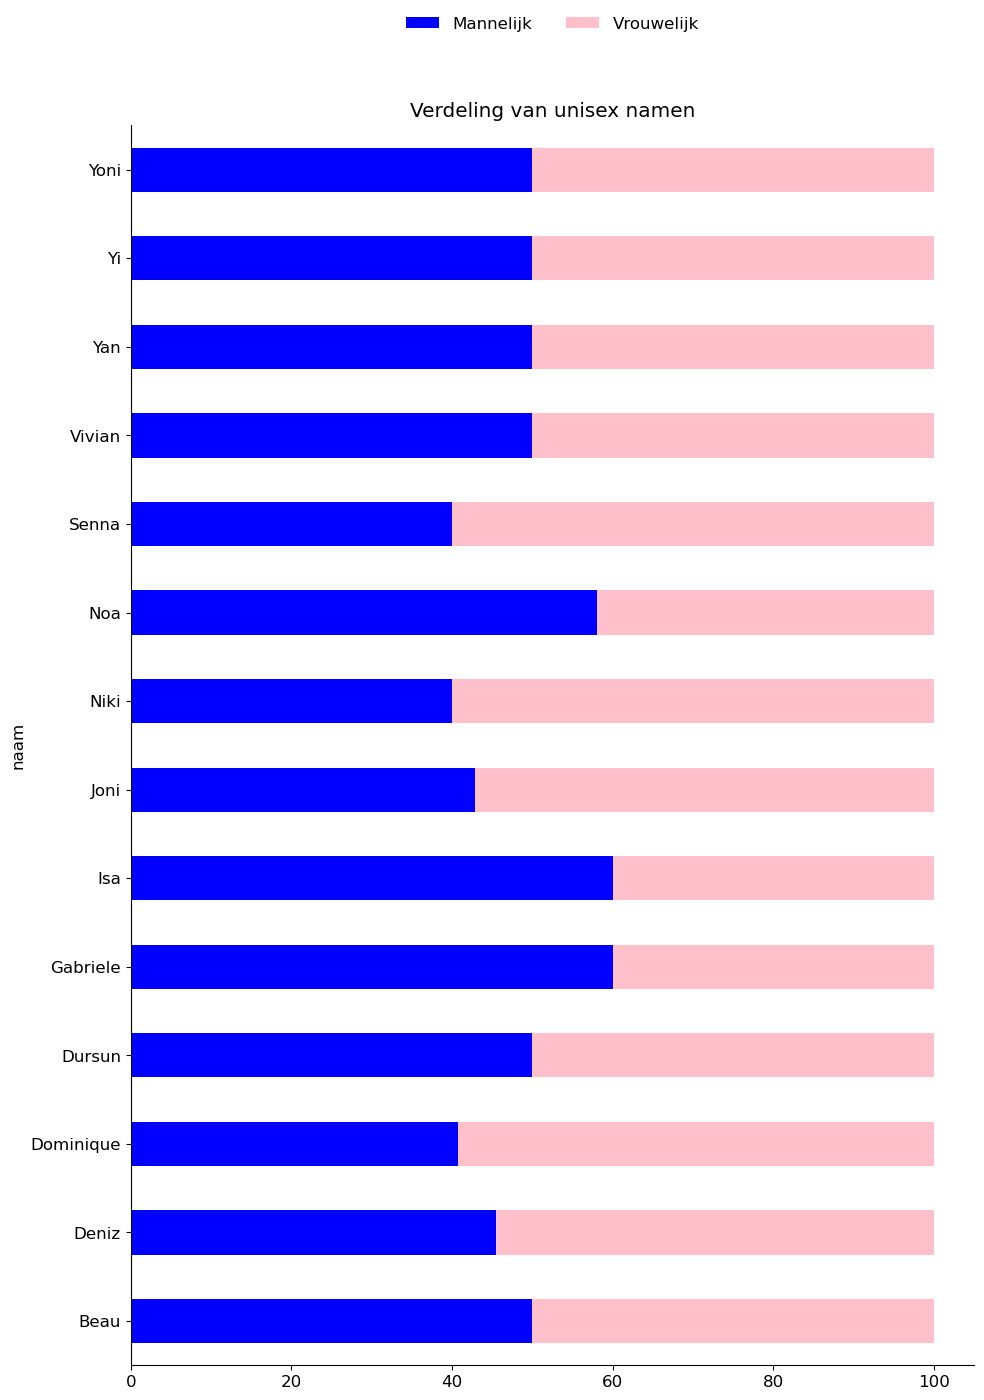

In [22]:
# Group by naam en geslacht
name_gender_counts = df_real_unisex.groupby(['naam', 'geslacht']).size().unstack(fill_value=0)
name_total_counts = name_gender_counts.sum(axis=1)

# Percentage per geslacht per naam
name_gender_percentages = name_gender_counts.div(name_total_counts, axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(10, 14))

name_gender_percentages.plot(kind='barh', stacked=True, color=['blue', 'pink'], ax=ax)

ax.set_title('Verdeling van unisex namen')
ax.legend(['Mannelijk', 'Vrouwelijk'], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.tight_layout()
plt.show()

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum
#### Evolutie vergelijken

Maak een afbeelding van het totaal aantal geboortes per dag en het totaal aantal verwachte geboortes.

**Bonusvraag**: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

<font color="blue">
De dataset gaat specifiek over geboortes in 2019 daarom staan er ook alleen geboortes in van 2019 maar een klein aantal daarvan werd verwacht eind 2018 of begin 2020, daarom begint de lijn van het aantal verwachte geboortes vroeger en gaat deze ook verder door. Het aantal is veel lager omdat de geboortes die ervoor of erna plaatsvonden, maar misschien ook op die data werden verwacht, niet in de dataset staan (nl. te laat geboren in 2018 of te vroeg geboren in 2020).

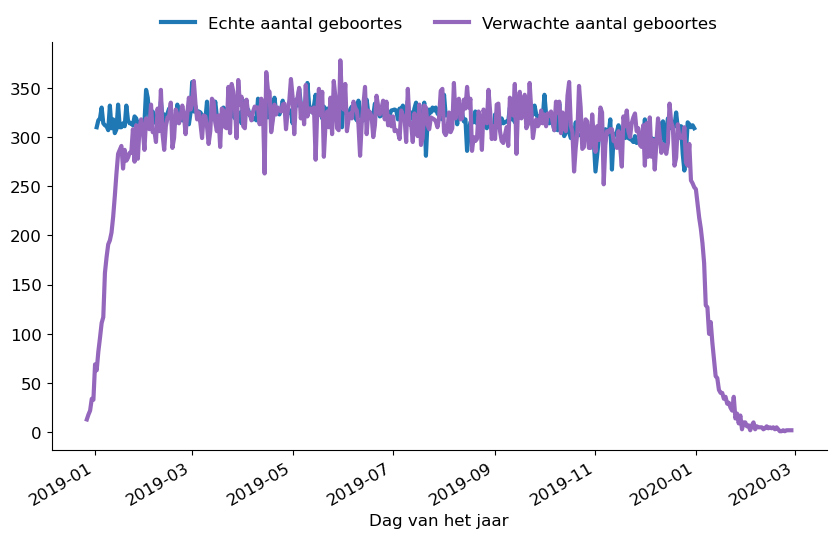

In [23]:
#Tel geboortes per dag
geboortes_per_dag = cleaned_df.groupby('geboortedag').size()
verwachte_geboortes_per_dag = cleaned_df.groupby('verwachte datum').size()

# Plot 
geboortes_per_dag.plot(label='Echte aantal geboortes')
verwachte_geboortes_per_dag.plot(label='Verwachte aantal geboortes')


plt.xlabel('Dag van het jaar')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

#### Verbanden bekijken
Maak een histogram van het aantal dagen dat babies te vroeg geboren werden in 2019 en een scatterplot die het verband toont tussen de verwachte en effectieve geboortedatum.

In [24]:
# Verschil berekenen (te vroeg wordt een negatief getal)
cleaned_df.loc[:, 'verschil'] = (cleaned_df['geboortedag'] - cleaned_df['verwachte datum']).dt.days

C:\Users\maiaf\AppData\Local\Temp\ipykernel_11984\391685454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.loc[:, 'verschil'] = (cleaned_df['geboortedag'] - cleaned_df['verwachte datum']).dt.days


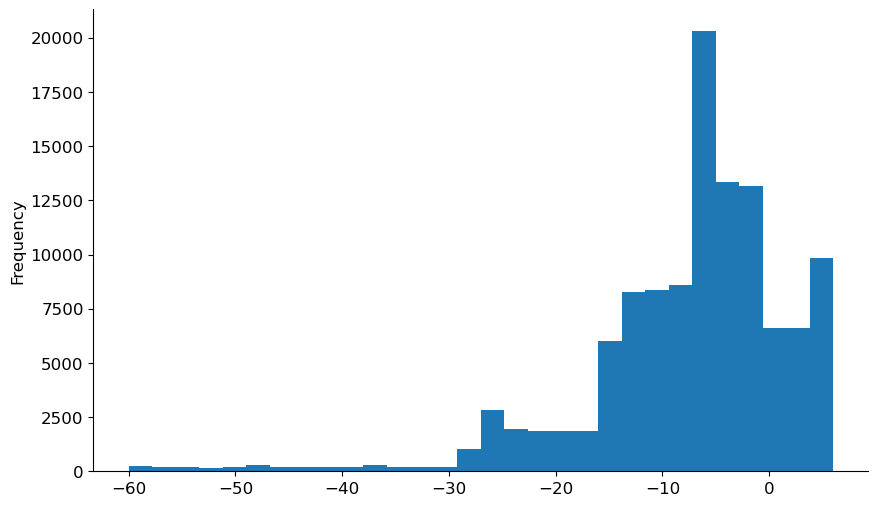

In [25]:
# Histogram
plt.hist(cleaned_df['verschil'], bins= 30)
plt.ylabel('Frequency')
plt.show()

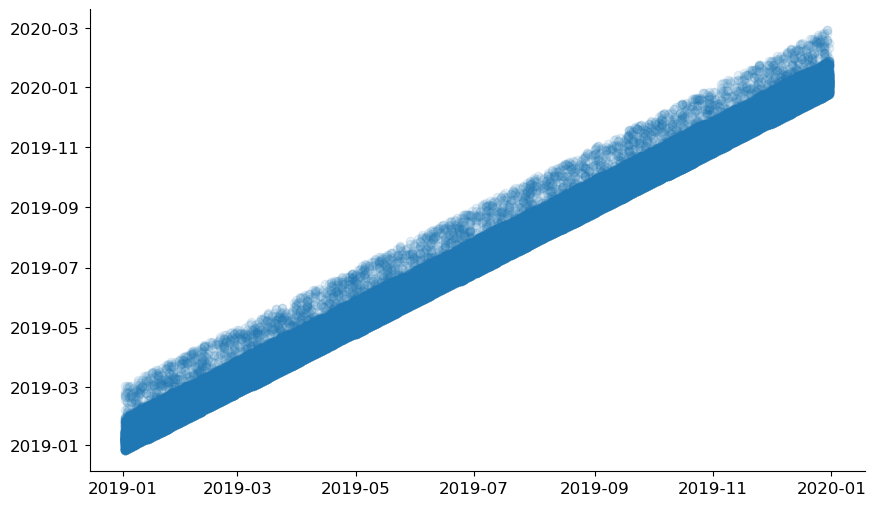

In [26]:
#Scatterplot
plt.scatter(cleaned_df['geboortedag'].values, cleaned_df['verwachte datum'], alpha=0.1)
plt.show()

### Onderzoek 3: Aantal namen versus aantal babies
Naarmate dat er meer babies geboren worden, gaan deze ook meer verschillende namen krijgen. Zolang er weinig babies geboren worden lijkt het logisch dat dit verband min of meer lineair is, maar naarmate dat er meer en meer babies geboren worden lijkt het niet meer logisch dat dit verband lineair blijft. We verwachten bijvoorbeeld niet dat het aantal unieke namen gegeven aan 2 miljoen babies het dubbel is van het aantal unieke namen gegeven aan 1 miljoen babies. Kan je op basis van deze dataset het verband tussen het aantal unieke namen in functie van het aantal babies eens onderzoeken? Hiervoor krijg je geen voorstel tot visualizatie maar moet je zelf mij proberen te overtuigen van je antwoord.

<font color="blue">
 Als eerste maak ik een plot dat het verband toont tussen het aantal geboorted en het aantal unieke namen. Er is duidelijk een positief verband.

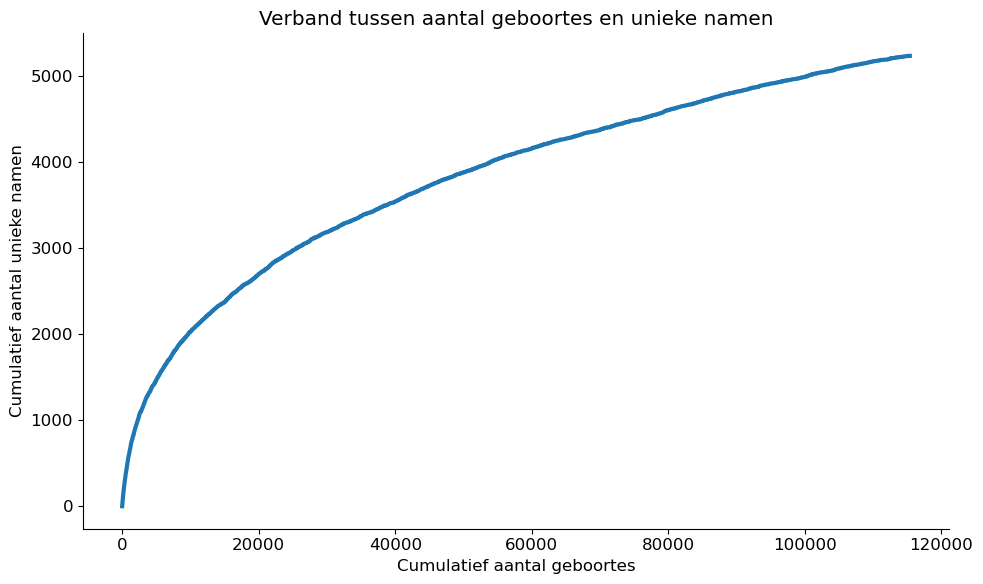

In [27]:
sorted_df = cleaned_df.sort_values(by='geboortedag')

# Lege lijst voor tellen geboortes en namen
cumulative_births = []
cumulative_unique_names = []
#Set zodat alleen unieke namen worden geteld
unique_names = set()

# Voor elke rij tel alleen de unieke namen en alle gebortes
for index, row in sorted_df.iterrows():
    unique_names.add(row['naam'])
    cumulative_births.append(len(cumulative_births))
    cumulative_unique_names.append(len(unique_names))

# Plot
plt.figure()
plt.plot(cumulative_births, cumulative_unique_names)

plt.xlabel('Cumulatief aantal geboortes')
plt.ylabel('Cumulatief aantal unieke namen')
plt.title('Verband tussen aantal geboortes en unieke namen')

plt.tight_layout()
plt.show()

<font color="blue">
 Op dit plot kan ook lineaire regressie worden toegepast om het verband aan te tonen, outliers te tonen (zoals dat het op het einde terug wat afzwakt en er in het begin weinig unieke namen zijn omdat er nog weinig baby's zijn). 

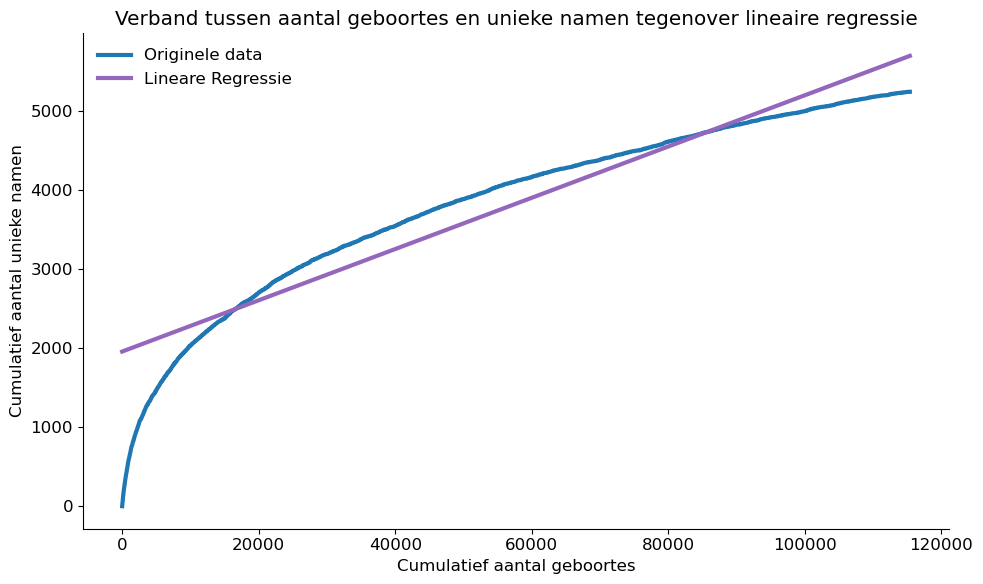

In [28]:
# Lijsten naar numpy arrays
cumulative_births_ar = np.array(cumulative_births).reshape(-1, 1)
cumulative_unique_names_ar = np.array(cumulative_unique_names)

# Lineaire regressie
regressor = LinearRegression()
regressor.fit(cumulative_births_ar, cumulative_unique_names_ar)

predicted_unique_names = regressor.predict(cumulative_births_ar)

# Origineel plot
plt.figure()
plt.plot(cumulative_births_ar, cumulative_unique_names_ar, label='Originele data')

# Plot lineare regressie
plt.plot(cumulative_births_ar, predicted_unique_names, label='Lineare Regressie')

plt.xlabel('Cumulatief aantal geboortes')
plt.ylabel('Cumulatief aantal unieke namen')
plt.title('Verband tussen aantal geboortes en unieke namen tegenover lineaire regressie')

plt.legend()
plt.tight_layout()
plt.show()

<font color="blue">
De correlatie coëfficient indiceert een sterke positieve correlatie.

In [29]:
correlation_coefficient = np.corrcoef(cumulative_births, cumulative_unique_names)[0, 1]

print("Correlatie coëfficient:")
print(correlation_coefficient)

Correlatie coëfficient:
0.9553756383832437
